In [1]:
pip install chemparse

In [2]:
import chemparse
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score,recall_score,f1_score,classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.base import clone

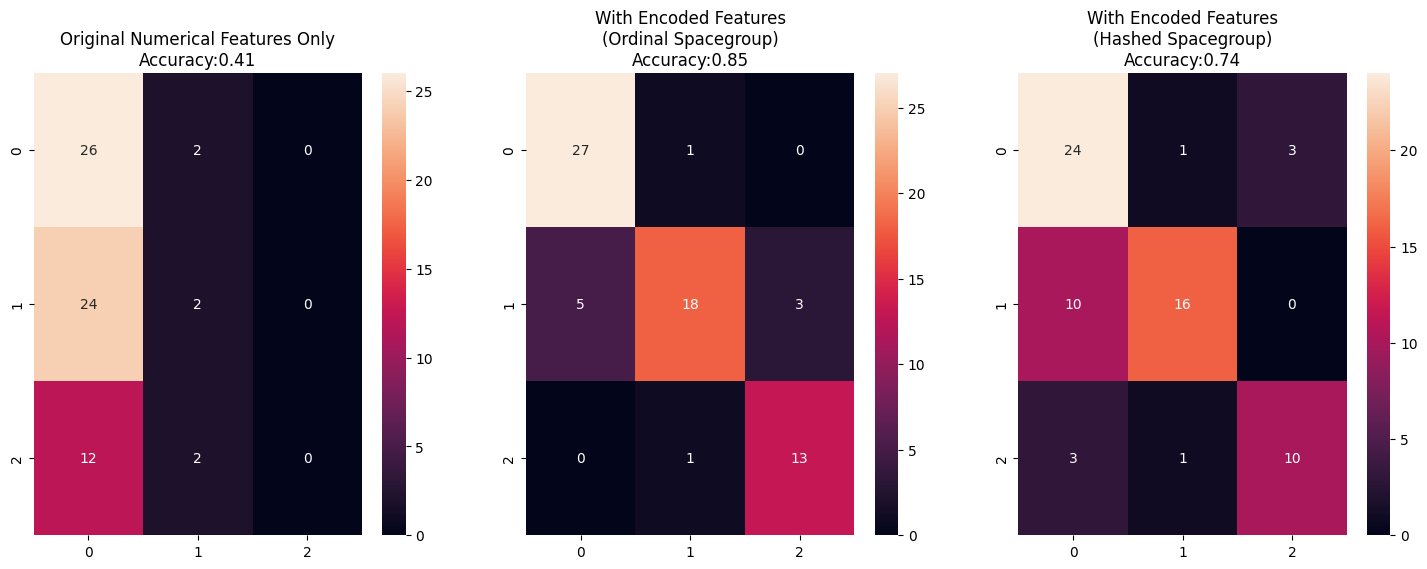

In [3]:
## Pre-processsing
# Load and display data
url = 'http://apmonitor.com/pds/uploads/Main/lithium_ion.txt'
data = pd.read_csv(url)
num_feat = data.select_dtypes(include=['int64','float64']).columns
cat_feat = data.select_dtypes(include=['object','bool']).columns
data.drop(columns=['Materials Id'], inplace=True)

# One-hot encode 'Has Bandstructure'
data['Has Bandstructure'] = data['Has Bandstructure'].map({True: 1, False: 0})

# Feature engineering
data['Spacegroup (ordinal)'] = pd.factorize(data['Spacegroup'])[0]

n = 3
# Convert 'Spacegroup' column into iterables of strings
spacegroup_iterables = data['Spacegroup'].apply(list)

# Use FeatureHasher
fh = FeatureHasher(n_features=n, input_type='string')
hashed_tag = fh.fit_transform(spacegroup_iterables).toarray()


ht_df = pd.DataFrame(hashed_tag, columns=['Spacegroup' + str(i) for i in range(n)])
data = data.join(ht_df)

chem_data = data['Formula'].apply(chemparse.parse_formula)
chem_data = pd.json_normalize(chem_data).fillna(0)
data = data.join(chem_data)

labelencoder = LabelEncoder()
data['Crystal System (#)'] = labelencoder.fit_transform(data['Crystal System'])

data[['monoclinic', 'orthorhombic', 'triclinic']] = pd.get_dummies(data['Crystal System'])

data.to_csv('lithium_ion_data.csv', index=False)

# Model training and evaluation
# Define features and labels
features = list(data.select_dtypes(include=['int64','float64']).columns.values)
ord_feat = ['Formation Energy (eV)', 'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)', 'Volume',
            'Has Bandstructure', 'Spacegroup (ordinal)', 'Li', 'Mn', 'Si', 'O', 'Fe', 'Co']
hash_feat = ['Formation Energy (eV)', 'E Above Hull (eV)', 'Band Gap (eV)', 'Nsites', 'Density (gm/cc)', 'Volume',
             'Has Bandstructure', 'Spacegroup0', 'Spacegroup1', 'Spacegroup2', 'Li', 'Mn', 'Si', 'O', 'Fe', 'Co']
labels = ['Crystal System (#)']

# Plotting confusion matrices

best_mlp = None
best_mlp2 = None
best_accuracy =  0.2



plt.figure(figsize=(18, 6))
titles = ['Original Numerical Features Only',
          'With Encoded Features\n(Ordinal Spacegroup)',
          'With Encoded Features\n(Hashed Spacegroup)']
for i, feat in enumerate([num_feat, ord_feat, hash_feat]):
    X = data[feat]
    y = data[labels].values.ravel()

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,random_state=3)

    mlp = MLPClassifier(activation = 'identity',solver = 'sgd',random_state = 42)
    #mlp = clone(best_mlp2)
    #mlp.activation = 'relu'
    mlp.fit(Xtrain, ytrain)
    yp = mlp.predict(Xtest)

    # Plot confusion matrix
    plt.subplot(1, 3, i + 1)
    cm = confusion_matrix(ytest, yp)
    sns.heatmap(cm, annot=True)
    accuracy = accuracy_score(ytest, yp).round(2)
    if(accuracy > best_accuracy) :
        best_accuracy = accuracy
        best_mlp = mlp
        best_mlp2 = mlp
    plt.title(titles[i] + "\nAccuracy:" + str(accuracy))


plt.savefig('diff_preprocessing_results.png')  # Save the plot to a file

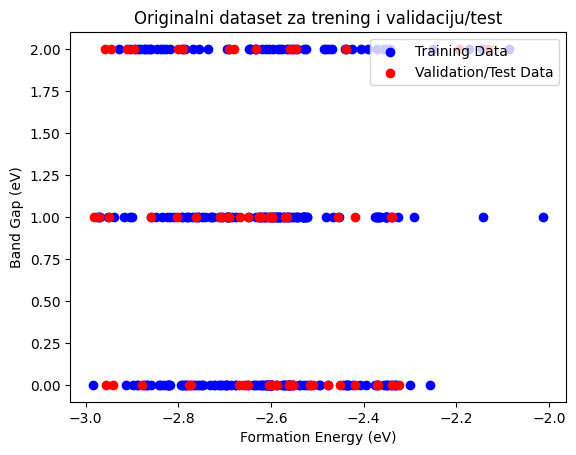

In [4]:

X_ = data[ord_feat]
y_ = data[labels] .values.ravel()
#y2=data[labels]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=3)

X_train
X_train_first_two = X_train.iloc[:, :2]
X_test_first_two = X_test.iloc[:, :2]

# Plot podataka za trening
plt.scatter(X_train_first_two.iloc[:, 0],y_train, color='blue', label='Training Data')

# Plot podataka za verifikaciju
plt.scatter(X_test_first_two.iloc[:, 0], y_test, color='red', label='Validation/Test Data')

plt.title('Originalni dataset za trening i validaciju/test')
plt.xlabel('Formation Energy (eV)')
plt.ylabel('Band Gap (eV)')
plt.legend()
plt.show()

#y2
#y_train


0.85
{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
42


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42
42
42
42
42
42


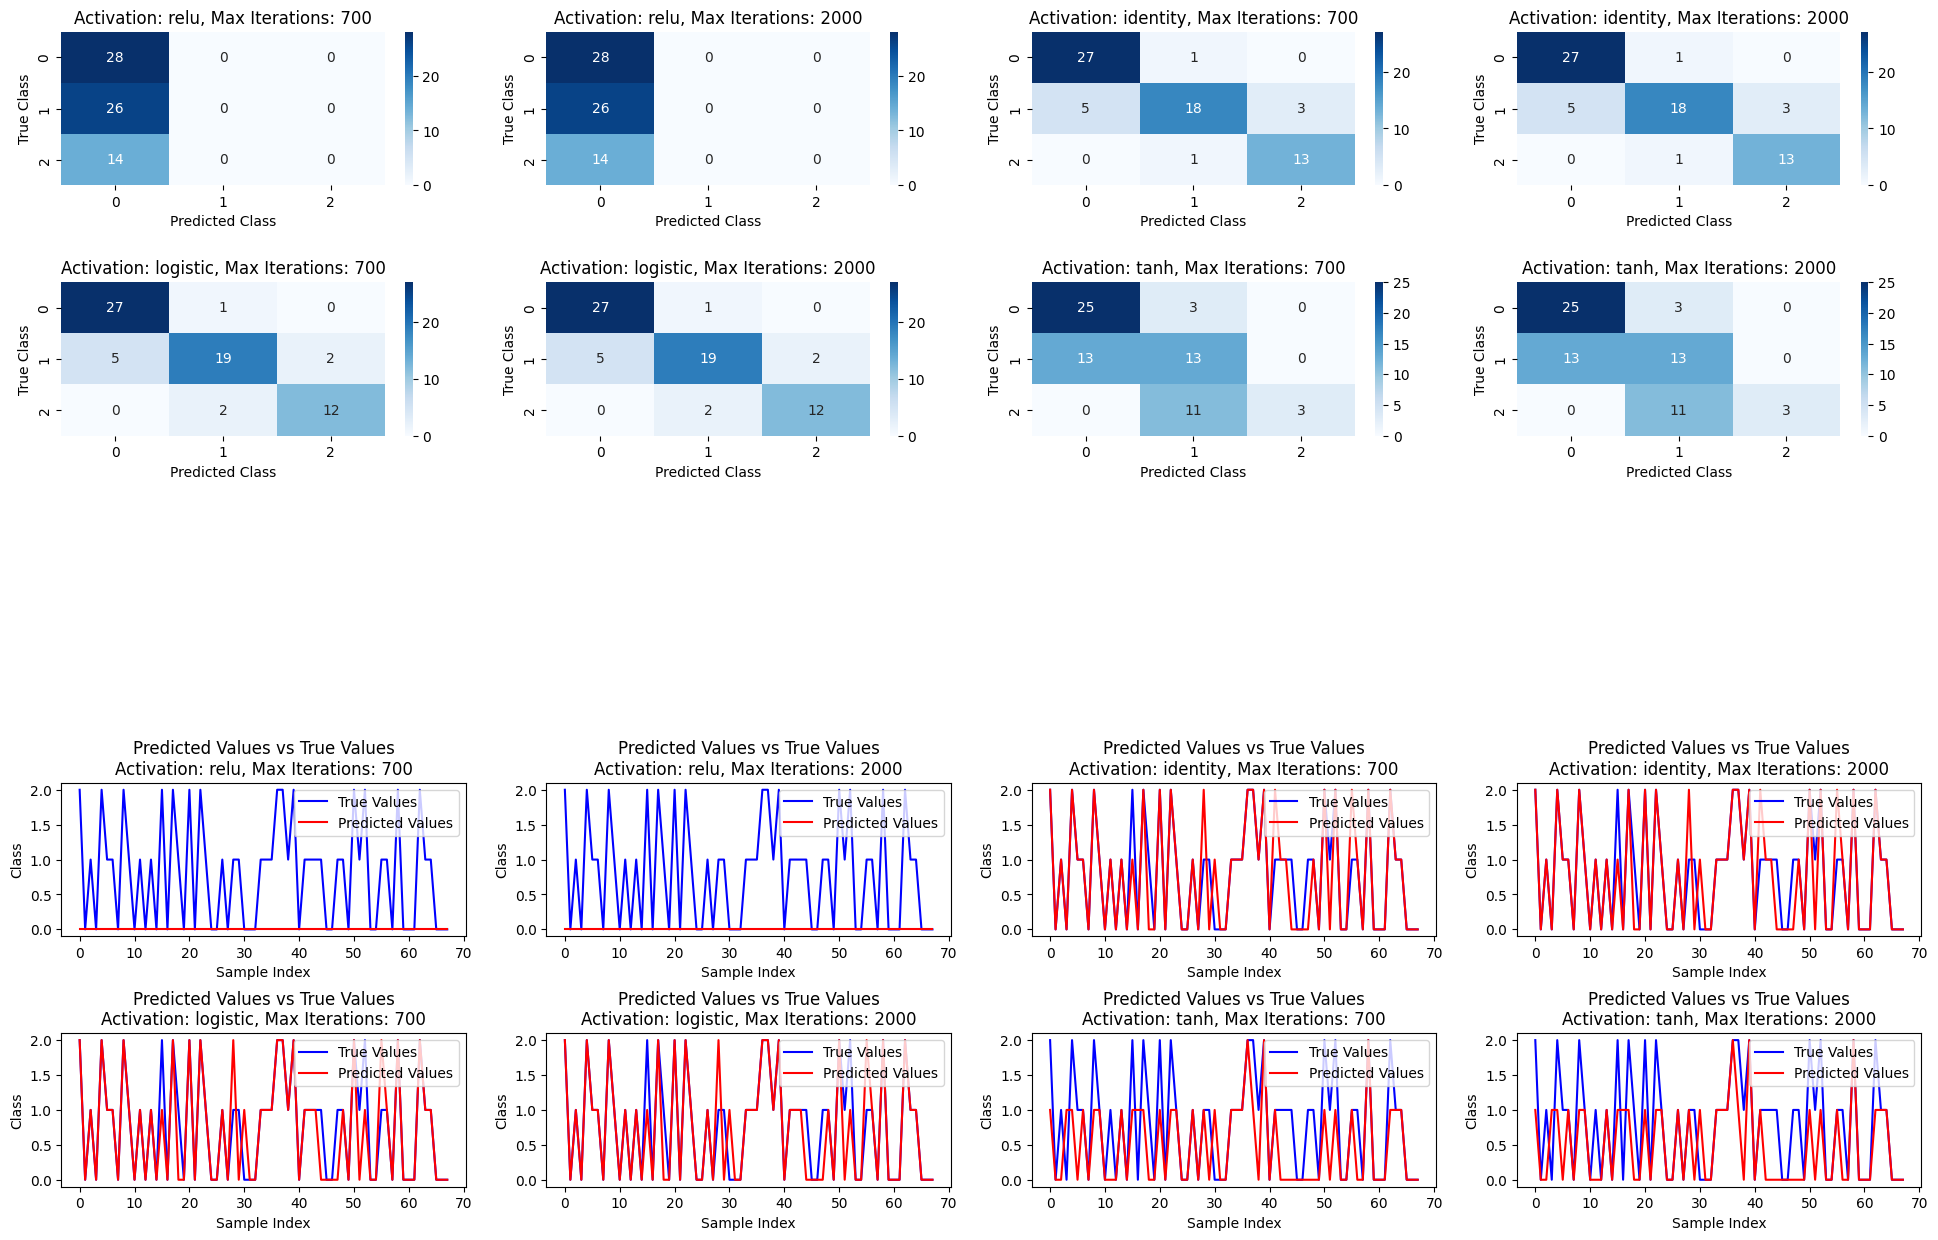

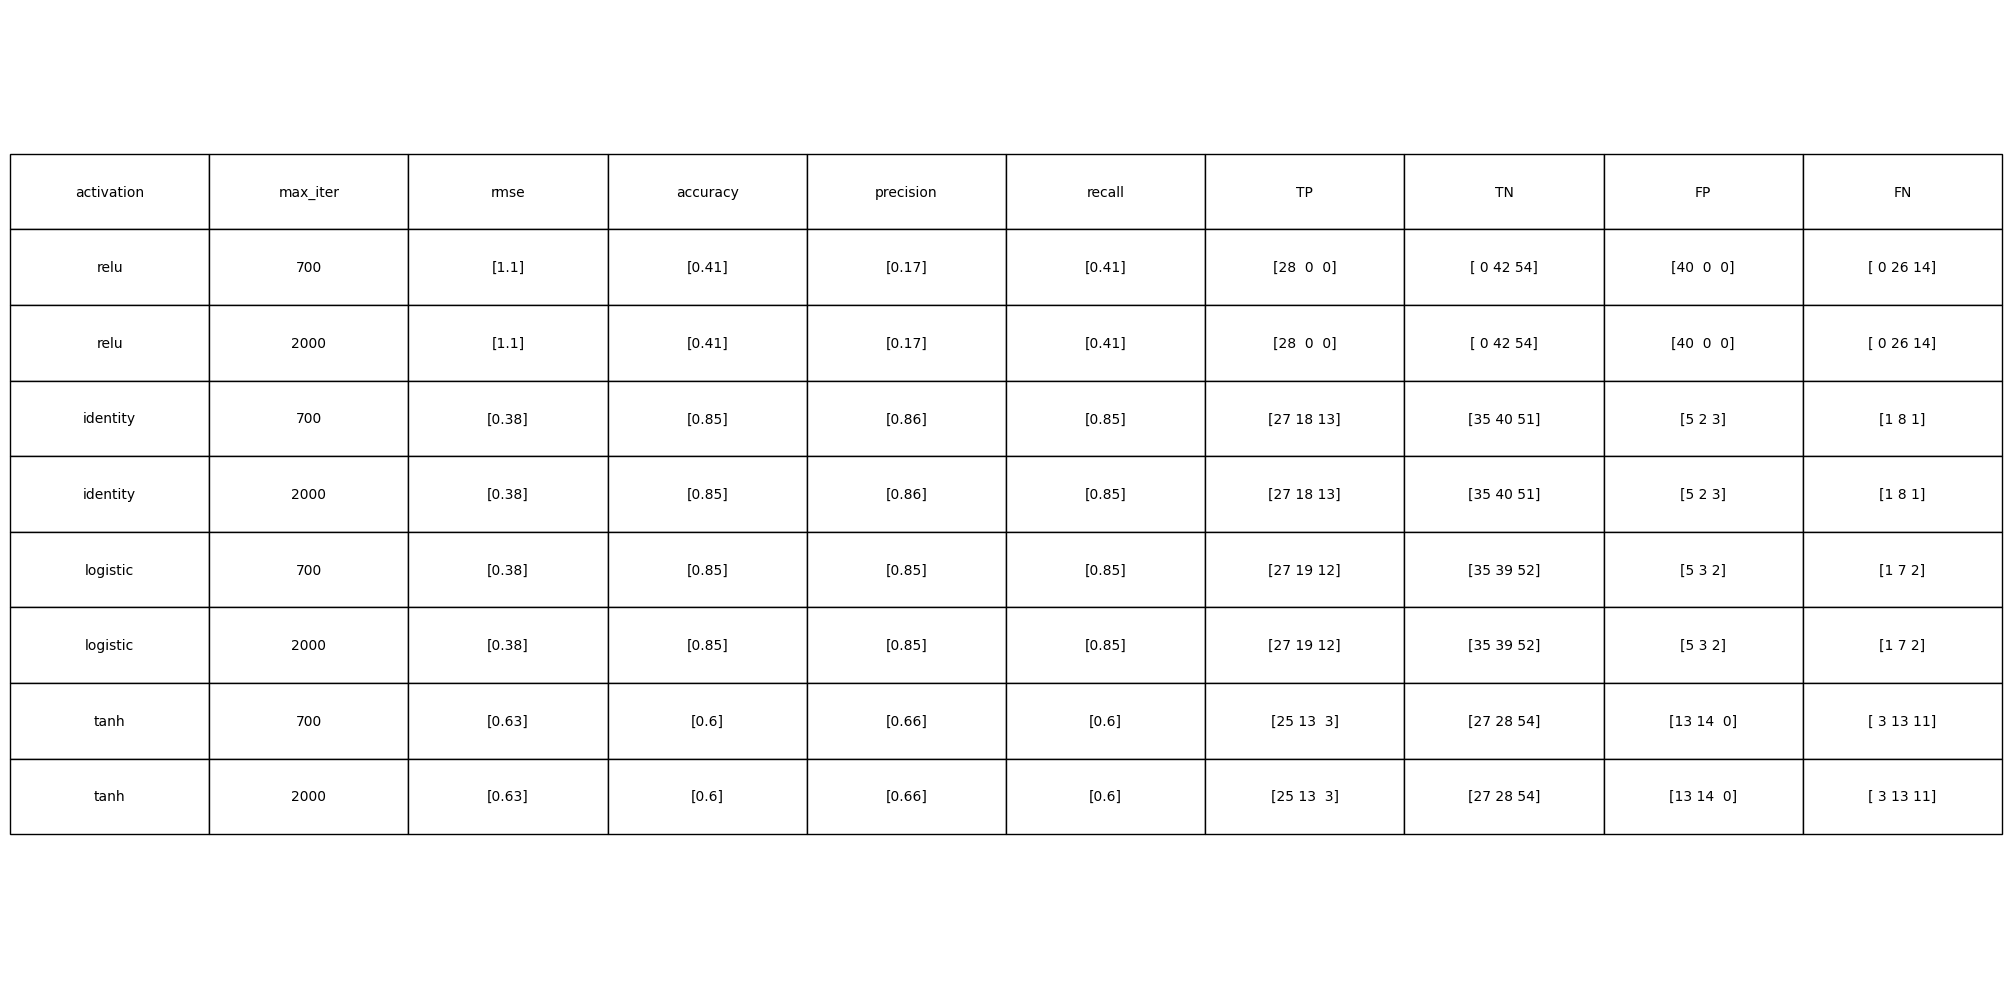

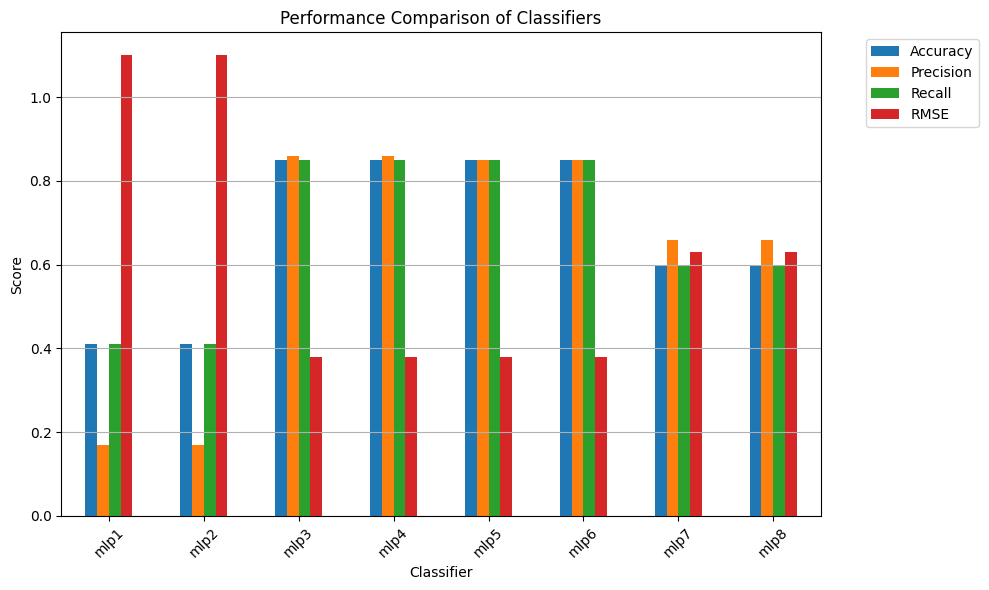

In [5]:
# Zadatak pod a)

# Define parameter grid
param_grid = {
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'max_iter': [700, 2000]
}

#best_mlp = MLPClassifier (activation ='identity',solver = 'sgd')
#best_mlp.fit(X_train,y_train)
#y_pred = best_mlp.predict(X_test)
#best_accuracy = accuracy_score(ytest, y_pred)
print(best_accuracy)
print(best_mlp2.get_params())
scores_a = []
# Initialize the results list
results_list = []
plt.figure(figsize=(24, 15))

# Perform manual GridSearchCV to capture all metrics
for i, activation in enumerate(param_grid['activation']):
    for j, max_iter in enumerate(param_grid['max_iter']):

        fold_results = {
            'activation': activation,
            'max_iter': max_iter,
            'rmse': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'TP': [],
            'TN': [],
            'FP': [],
            'FN': []
        }
        name = f'mlp{i*len(param_grid["max_iter"])+j+1}'
        #mlp = MLPClassifier(activation=activation, max_iter=max_iter,solver = 'sgd')
        mlp = clone(best_mlp)
        print(mlp.random_state)
        mlp.set_params(activation=activation, max_iter=max_iter)
        # Train the model
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)






        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Calculate TP, TN, FP, FN for each class
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        FPR = FP/(FP+TN)

        # Define subplot positions
        plt.subplot(5, 4, i * len(param_grid['max_iter']) + j + 1)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Activation: {activation}, Max Iterations: {max_iter}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('MLP_konfmatrica_a.png')



        # Calculate metrics
        rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(2)
        accuracy = accuracy_score(y_test, y_pred).round(2)
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_mlp2 = mlp
            best_mlp = mlp

        precision = precision_score(y_test, y_pred, average='weighted').round(2)
        recall = recall_score(y_test, y_pred, average='weighted').round(2)

        score_dict = {'Classifier': name,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'RMSE': rmse }
        scores_a.append(score_dict)


        fold_results['rmse'].append(rmse)
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['TP'] = TP
        fold_results['TN'] = TN
        fold_results['FP'] = FP
        fold_results['FN'] = FN

        plt.subplot(5, 4, i * len(param_grid['max_iter']) + j + 13)  # Za predikcije
        plt.plot(y_test, color='blue', label='True Values')
        plt.plot(y_pred, color='red', label='Predicted Values')
        plt.title(f'Predicted Values vs True Values\nActivation: {activation}, Max Iterations: {max_iter}')
        plt.xlabel('Sample Index')
        plt.ylabel('Class')
        plt.legend()

        results_list.append(fold_results)
plt.subplots_adjust(hspace=0.63)
results_df = pd.DataFrame(results_list).round(2).astype(str)
plt.figure(figsize=(20, 10))
# Plot the table
plt.axis('off')  # Turn off the axis
tbl = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 3.6)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('MLP_tabela_a.png')

model_compare = pd.DataFrame(scores_a)

# Plotting
model_compare.set_index('Classifier', inplace=True)  # Postavljanje klasifikatora kao indeksa
model_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotacija oznaka na x-osi za bolju čitljivost
plt.grid(axis='y')  # Prikaz mreže na y-osi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Prikaz legende izvan grafikona
plt.tight_layout()  # Postavljanje razmaka između podataka radi bolje čitljivosti
plt.show()

0.85
{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


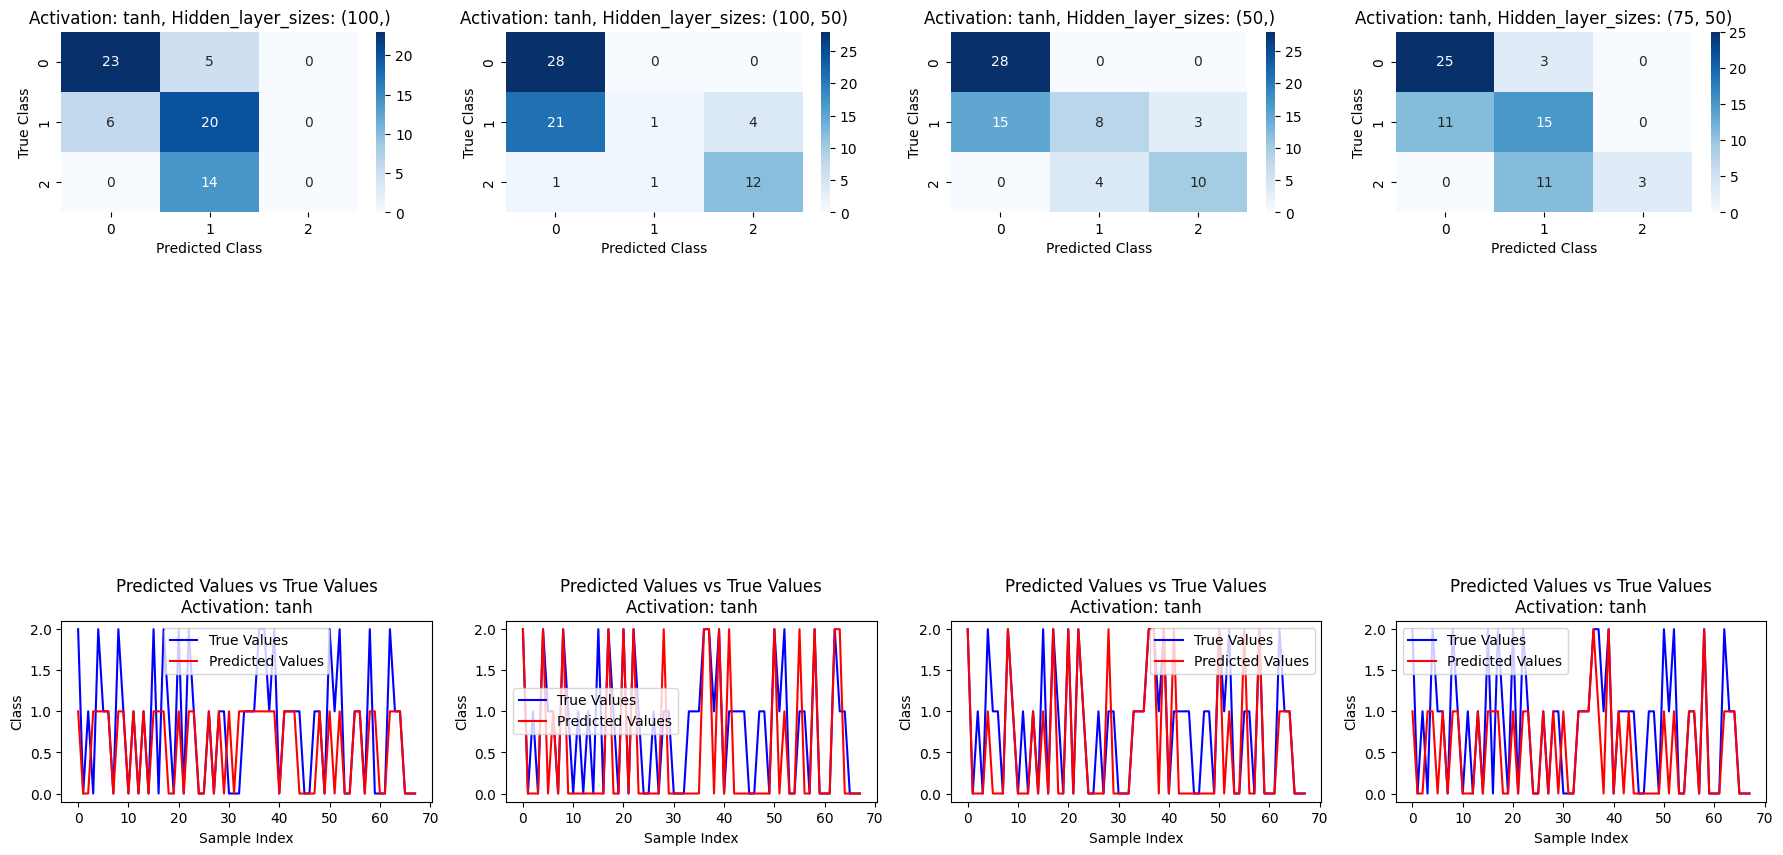

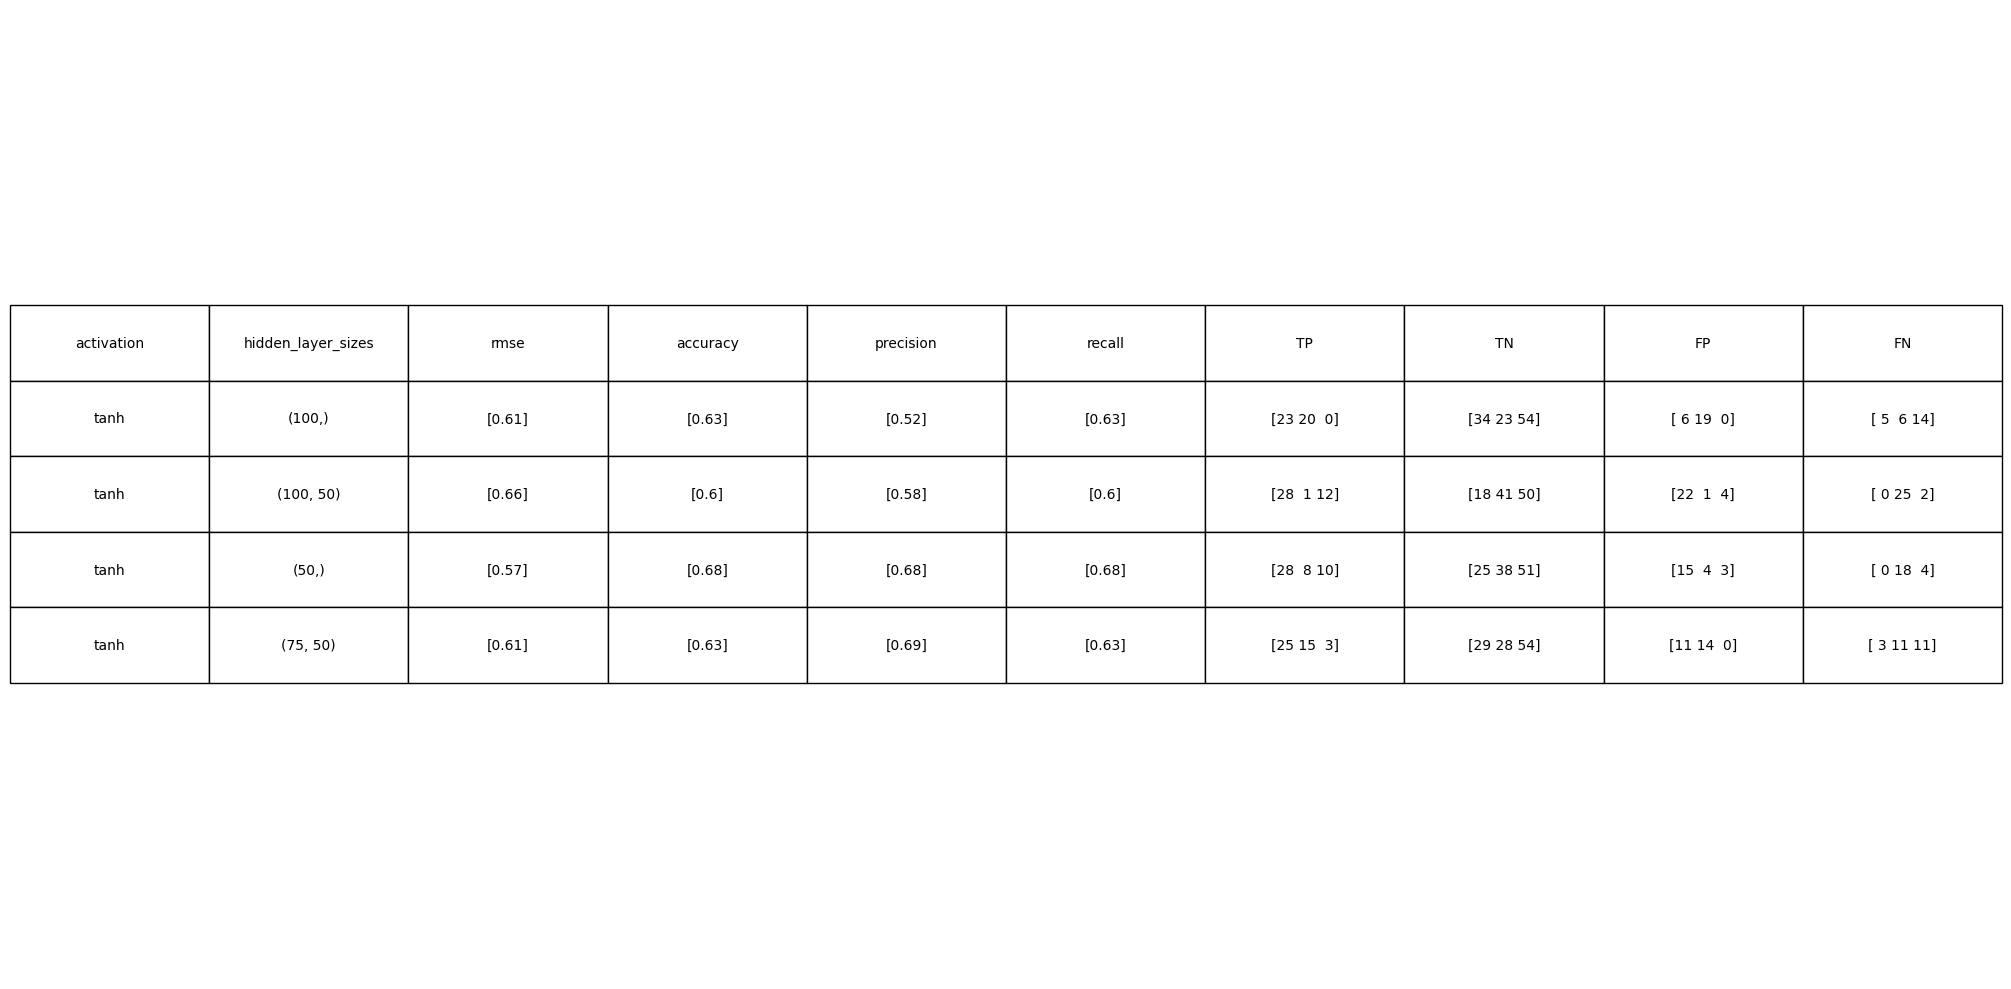

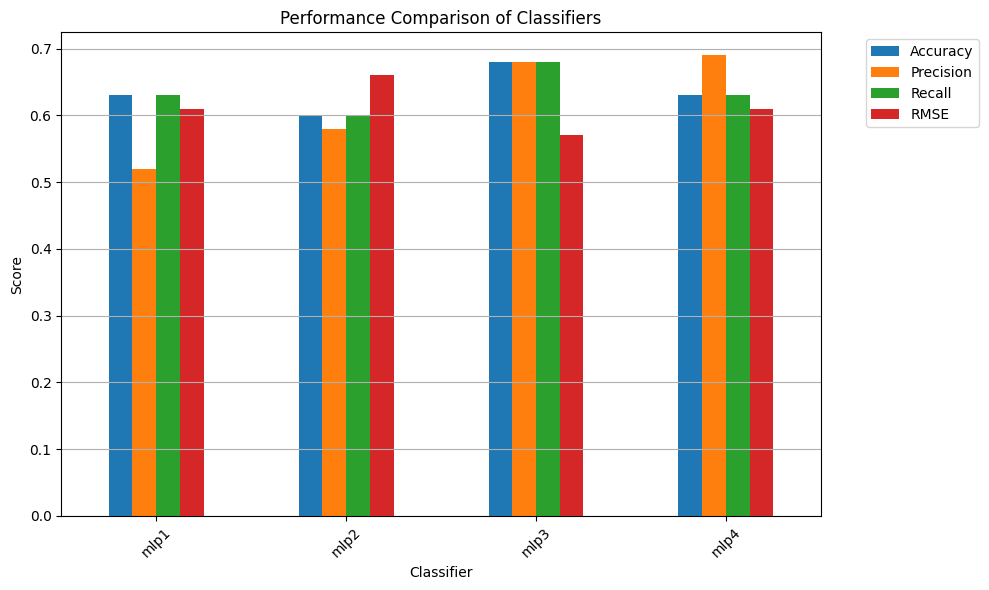

In [6]:
# Zadatak pod b)
print(best_accuracy)
print(best_mlp2.get_params())
param_grid = {
    'activation': ['tanh'],

    'hidden_layer_sizes': [(100,), (100, 50), (50,),(75,50)]
}

# Initialize the results list
results_list = []
plt.figure(figsize=(22, 10))

scores_b = []
# Perform manual GridSearchCV to capture all metrics
for i, activation in enumerate(param_grid['activation']):
    for j, layers in enumerate(param_grid['hidden_layer_sizes']):
        fold_results = {
            'activation': activation,
            'hidden_layer_sizes' : layers,
            'rmse': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'TP': [],
            'TN': [],
            'FP': [],
            'FN': []
        }
        name = f'mlp{i*len(param_grid["hidden_layer_sizes"])+j+1}'

        #mlp = MLPClassifier(max_iter=500,activation=activation, hidden_layer_sizes=layers, random_state=3)
        mlp = clone(best_mlp)
        mlp.set_params(activation=activation, hidden_layer_sizes=layers, random_state=3)

        # Train the model
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Calculate TP, TN, FP, FN for each class
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        # Define subplot positions
        plt.subplot(3, 4, i * len(param_grid['hidden_layer_sizes']) + j + 1)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Activation: {activation}, Hidden_layer_sizes: {layers}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('MLP_konfmatrica_b.png')

        # Calculate metrics
        rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(2)
        accuracy = accuracy_score(y_test, y_pred).round(2)
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_mlp2 = mlp
            best_mlp = mlp
        precision = precision_score(y_test, y_pred, average='weighted').round(2)
        recall = recall_score(y_test, y_pred, average='weighted').round(2)

        score_dict = {'Classifier': name,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'RMSE': rmse }
        scores_b.append(score_dict)


        fold_results['rmse'].append(rmse)
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['TP'] = TP
        fold_results['TN'] = TN
        fold_results['FP'] = FP
        fold_results['FN'] = FN

        plt.subplot(3, 4, i * len(param_grid['hidden_layer_sizes']) + j + 9)  # Za predikcije
        plt.plot(y_test, color='blue', label='True Values')
        plt.plot(y_pred, color='red', label='Predicted Values')
        plt.title(f'Predicted Values vs True Values\nActivation: {activation}')
        plt.xlabel('Sample Index')
        plt.ylabel('Class')
        plt.legend()

        results_list.append(fold_results)

plt.subplots_adjust(hspace=0.63) #razmak izmedju redova
# Create DataFrame from results_list
results_df = pd.DataFrame(results_list).astype(str)
plt.figure(figsize=(20, 10))
# Plot the table
plt.axis('off')  # Turn off the axis
tbl = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 3.6)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('MLP_tabela_b.png')

model_compare = pd.DataFrame(scores_b)

# Plotting
model_compare.set_index('Classifier', inplace=True)  # Postavljanje klasifikatora kao indeksa
model_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotacija oznaka na x-osi za bolju čitljivost
plt.grid(axis='y')  # Prikaz mreže na y-osi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Prikaz legende izvan grafikona
plt.tight_layout()  # Postavljanje razmaka između podataka radi bolje čitljivosti
plt.show()



0.85
{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


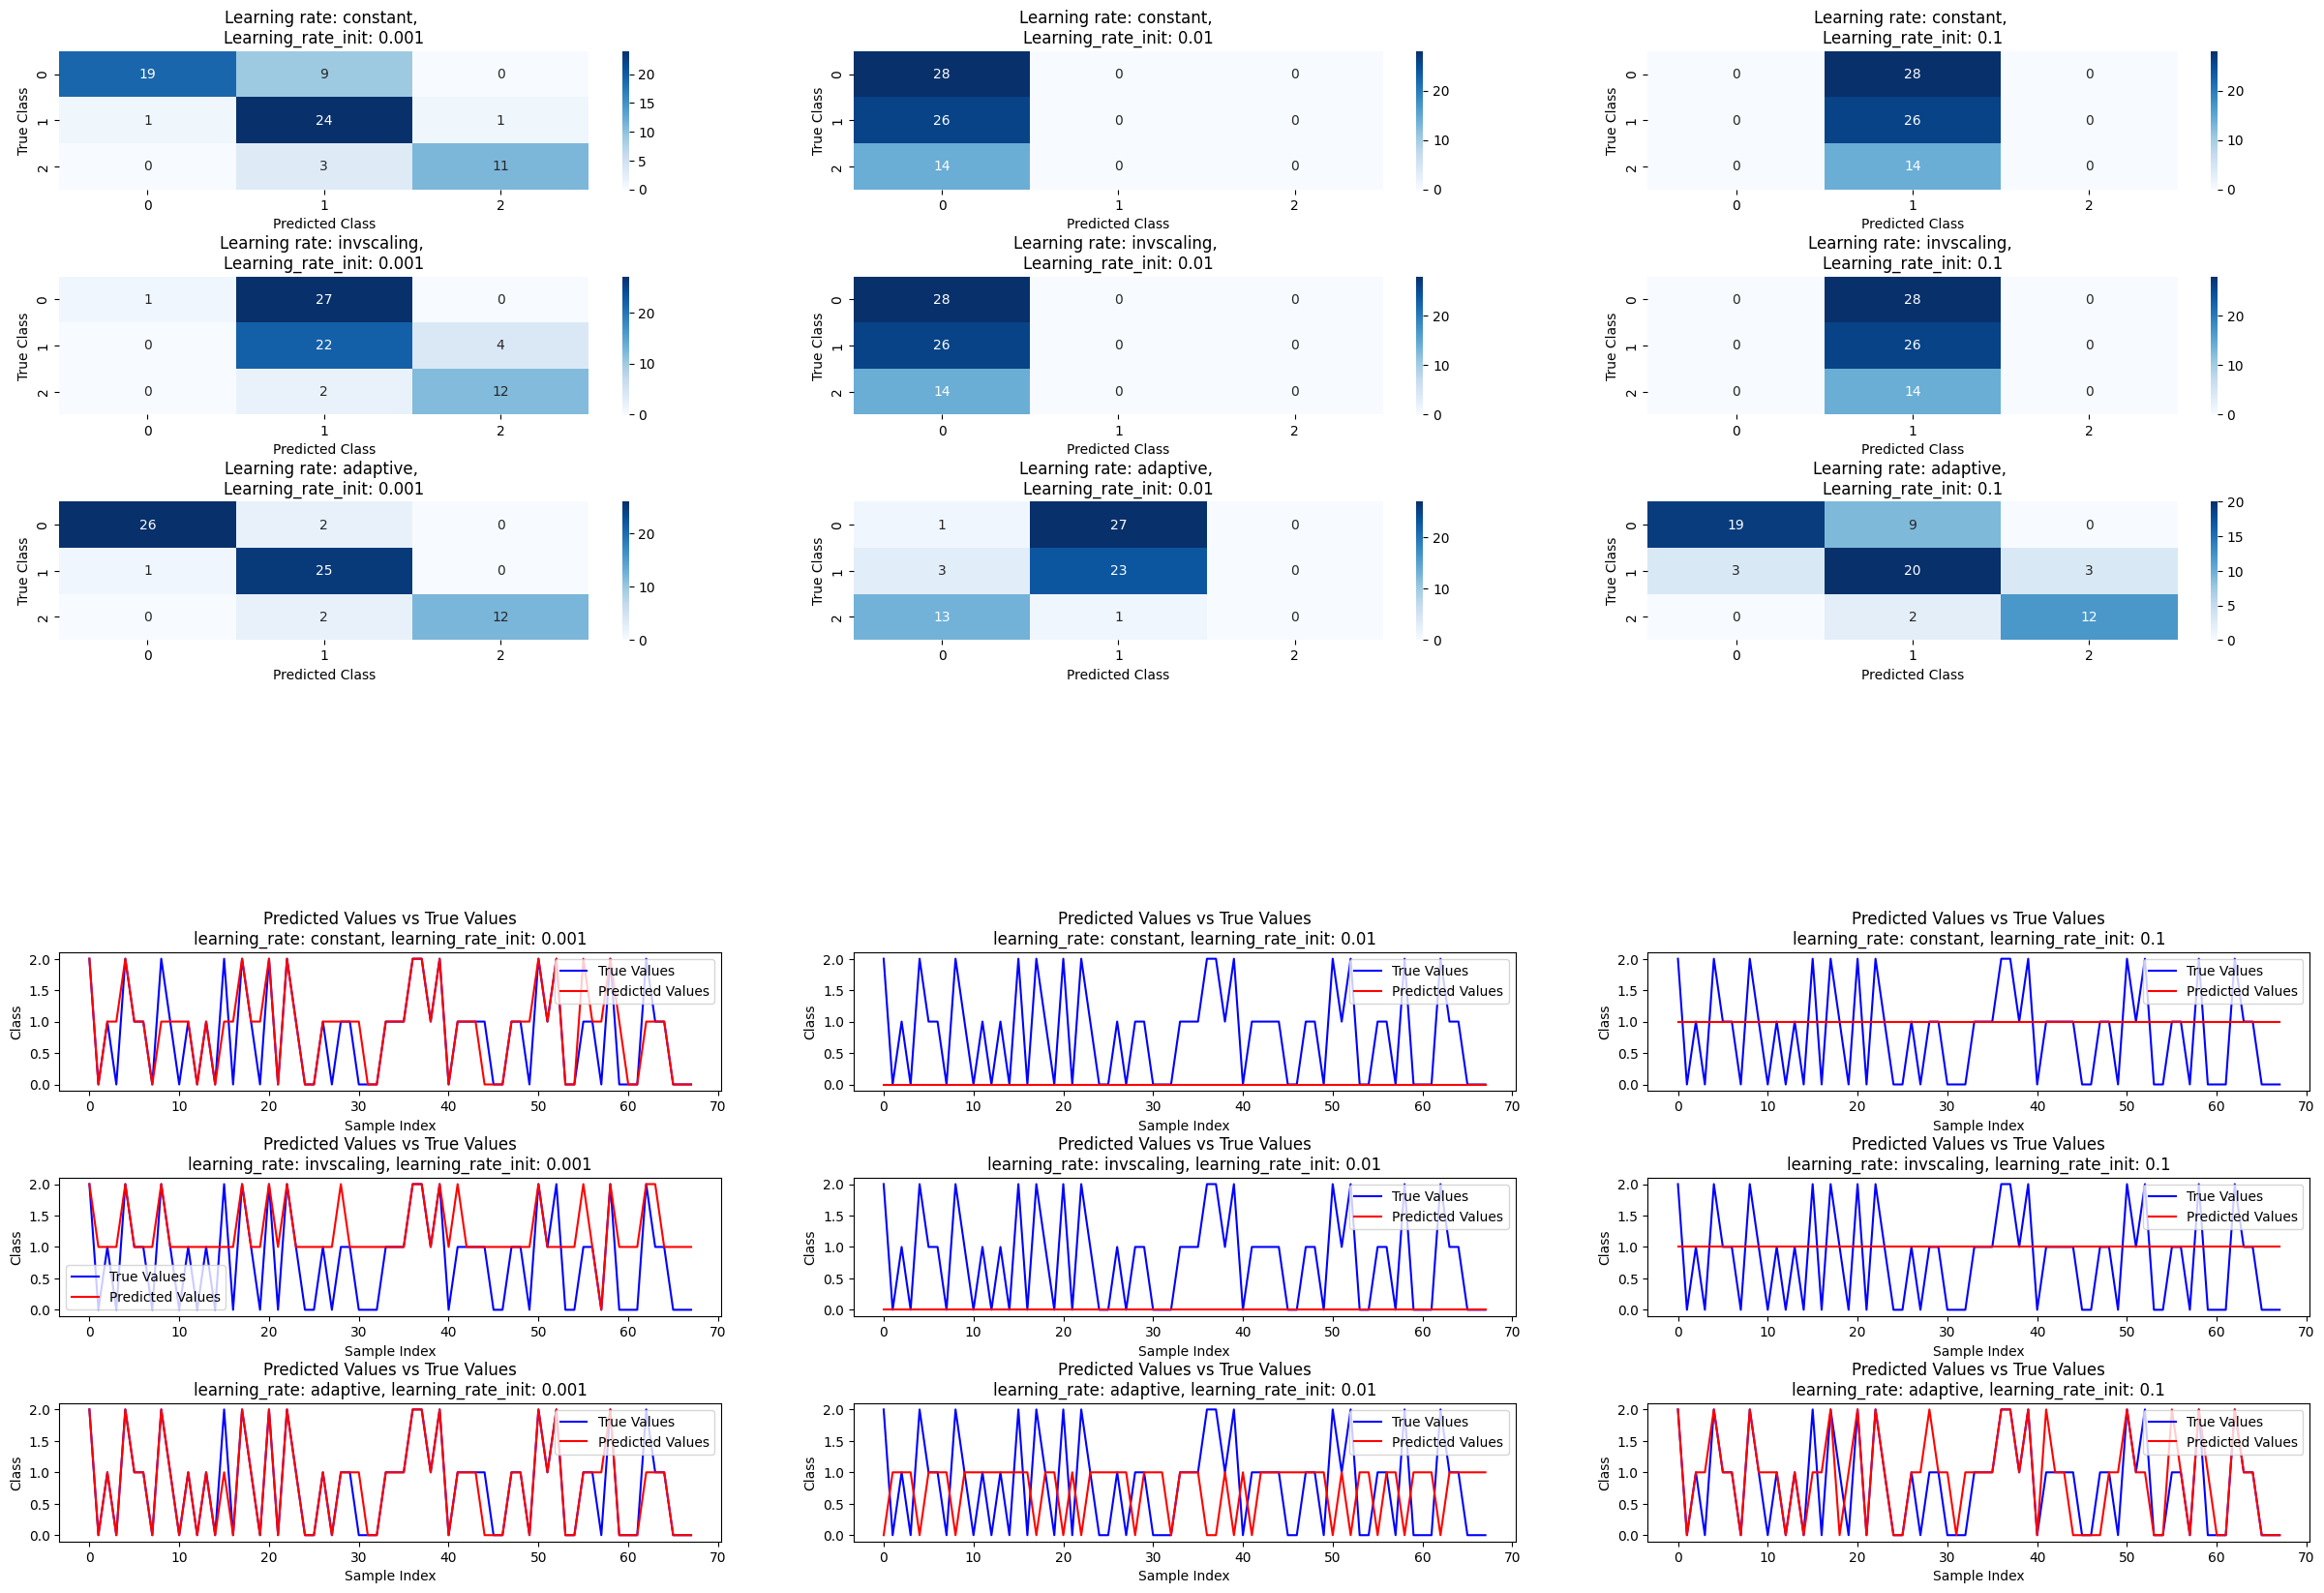

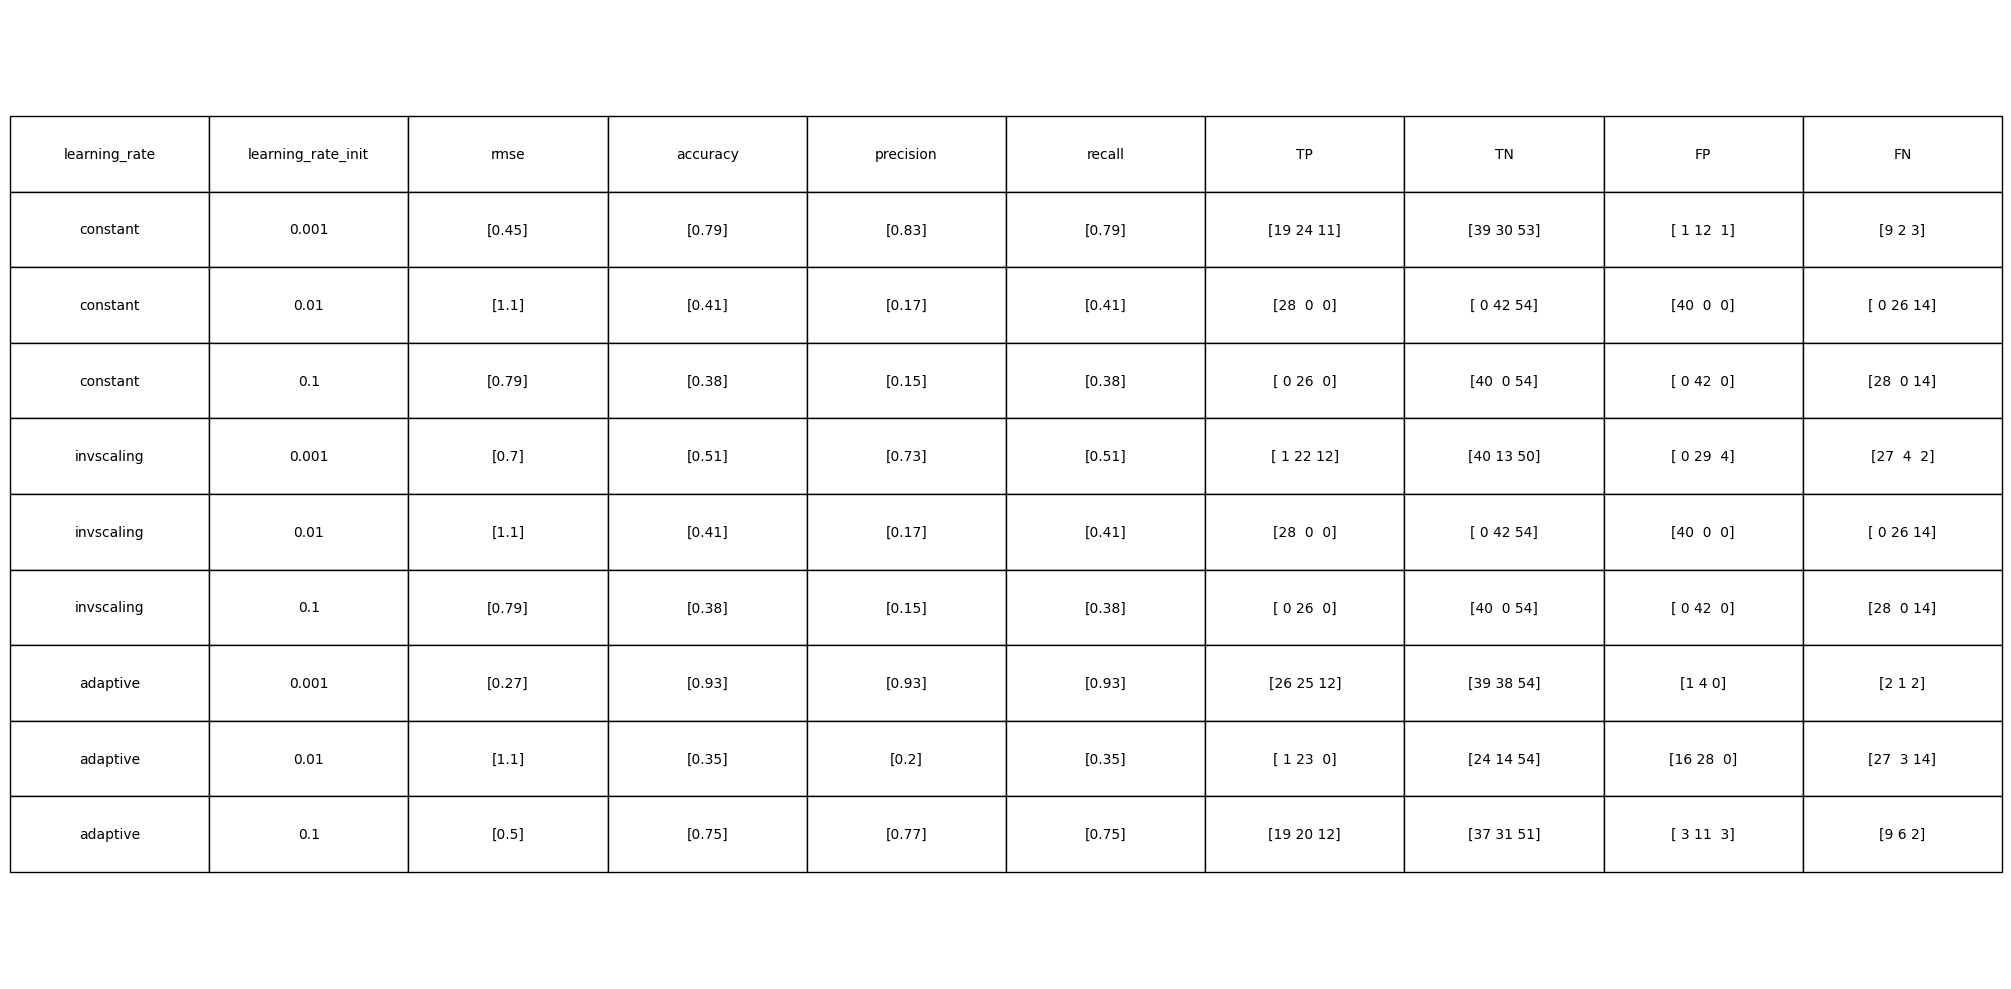

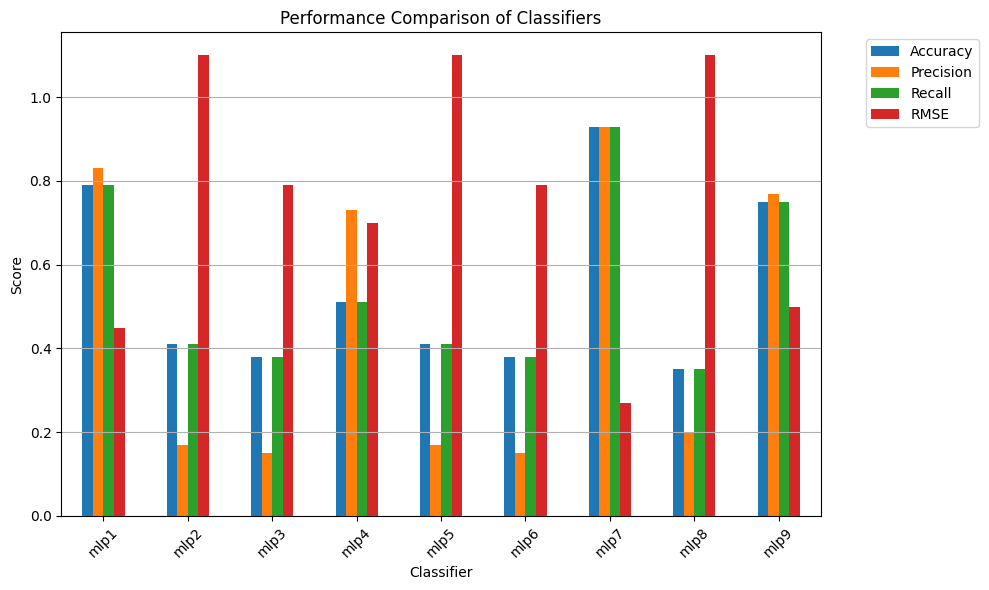

In [7]:
# Zadatak pod c)
print(best_accuracy)
print(best_mlp2.get_params())
param_grid = {

    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Dodajte različite vrijednosti za learning rate
    'learning_rate_init': [0.001, 0.01, 0.1]  # Dodajte različite vrijednosti learning ratea
}

# Initialize the results list
results_list = []
plt.figure(figsize=(30, 20))
scores_c = []


# Perform manual GridSearchCV to capture all metrics
for i, learning_rate in enumerate(param_grid['learning_rate']):
    for j, learning_init in enumerate(param_grid['learning_rate_init']):

        fold_results = {
            'learning_rate': learning_rate,
            'learning_rate_init': learning_init,
            'rmse': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'TP': [],
            'TN': [],
            'FP': [],
            'FN': []
        }
        name = f'mlp{i*len(param_grid["learning_rate_init"])+j+1}'

        #mlp = MLPClassifier(max_iter=500,learning_rate_init=learning_init, learning_rate=learning_rate, random_state=3)
        mlp = clone(best_mlp)
        mlp.set_params(max_iter=500,learning_rate_init=learning_init, learning_rate=learning_rate, random_state=3)
        # Train the model
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Calculate TP, TN, FP, FN for each class
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        # Define subplot positions
        plt.subplot(7, 3, i * len(param_grid['learning_rate_init']) + j + 1)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Learning rate: {learning_rate}, \nLearning_rate_init: {learning_init}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('MLP_konfmatrica_c.png')

        # Calculate metrics
        rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(2)
        accuracy = accuracy_score(y_test, y_pred).round(2)
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_mlp2 = mlp
            best_mlp = mlp
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0).round(2)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0).round(2)

        score_dict = {'Classifier': name,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'RMSE': rmse }
        scores_c.append(score_dict)
        fold_results['rmse'].append(rmse)
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['TP'] = TP
        fold_results['TN'] = TN
        fold_results['FP'] = FP
        fold_results['FN'] = FN

        plt.subplot(7, 3, i * len(param_grid['learning_rate_init']) + j + 13)  # Za predikcije
        plt.plot(y_test, color='blue', label='True Values')
        plt.plot(y_pred, color='red', label='Predicted Values')
        plt.title(f'Predicted Values vs True Values\nlearning_rate: {learning_rate}, learning_rate_init: {learning_init}')
        plt.xlabel('Sample Index')
        plt.ylabel('Class')
        plt.legend()

        results_list.append(fold_results)

plt.subplots_adjust(hspace=0.63) #razmak izmedju redova

# Create DataFrame from results_list
results_df = pd.DataFrame(results_list).astype(str)
#print(results_df)
plt.figure(figsize=(20, 10))
# Plot the table
plt.axis('off')  # Turn off the axis
tbl = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 3.6)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('MLP_tabela_c.png')

# Plotting
model_compare = pd.DataFrame(scores_c)

model_compare.set_index('Classifier', inplace=True)  # Postavljanje klasifikatora kao indeksa
model_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotacija oznaka na x-osi za bolju čitljivost
plt.grid(axis='y')  # Prikaz mreže na y-osi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Prikaz legende izvan grafikona
plt.tight_layout()  # Postavljanje razmaka između podataka radi bolje čitljivosti
plt.show()



0.93
{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 3, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


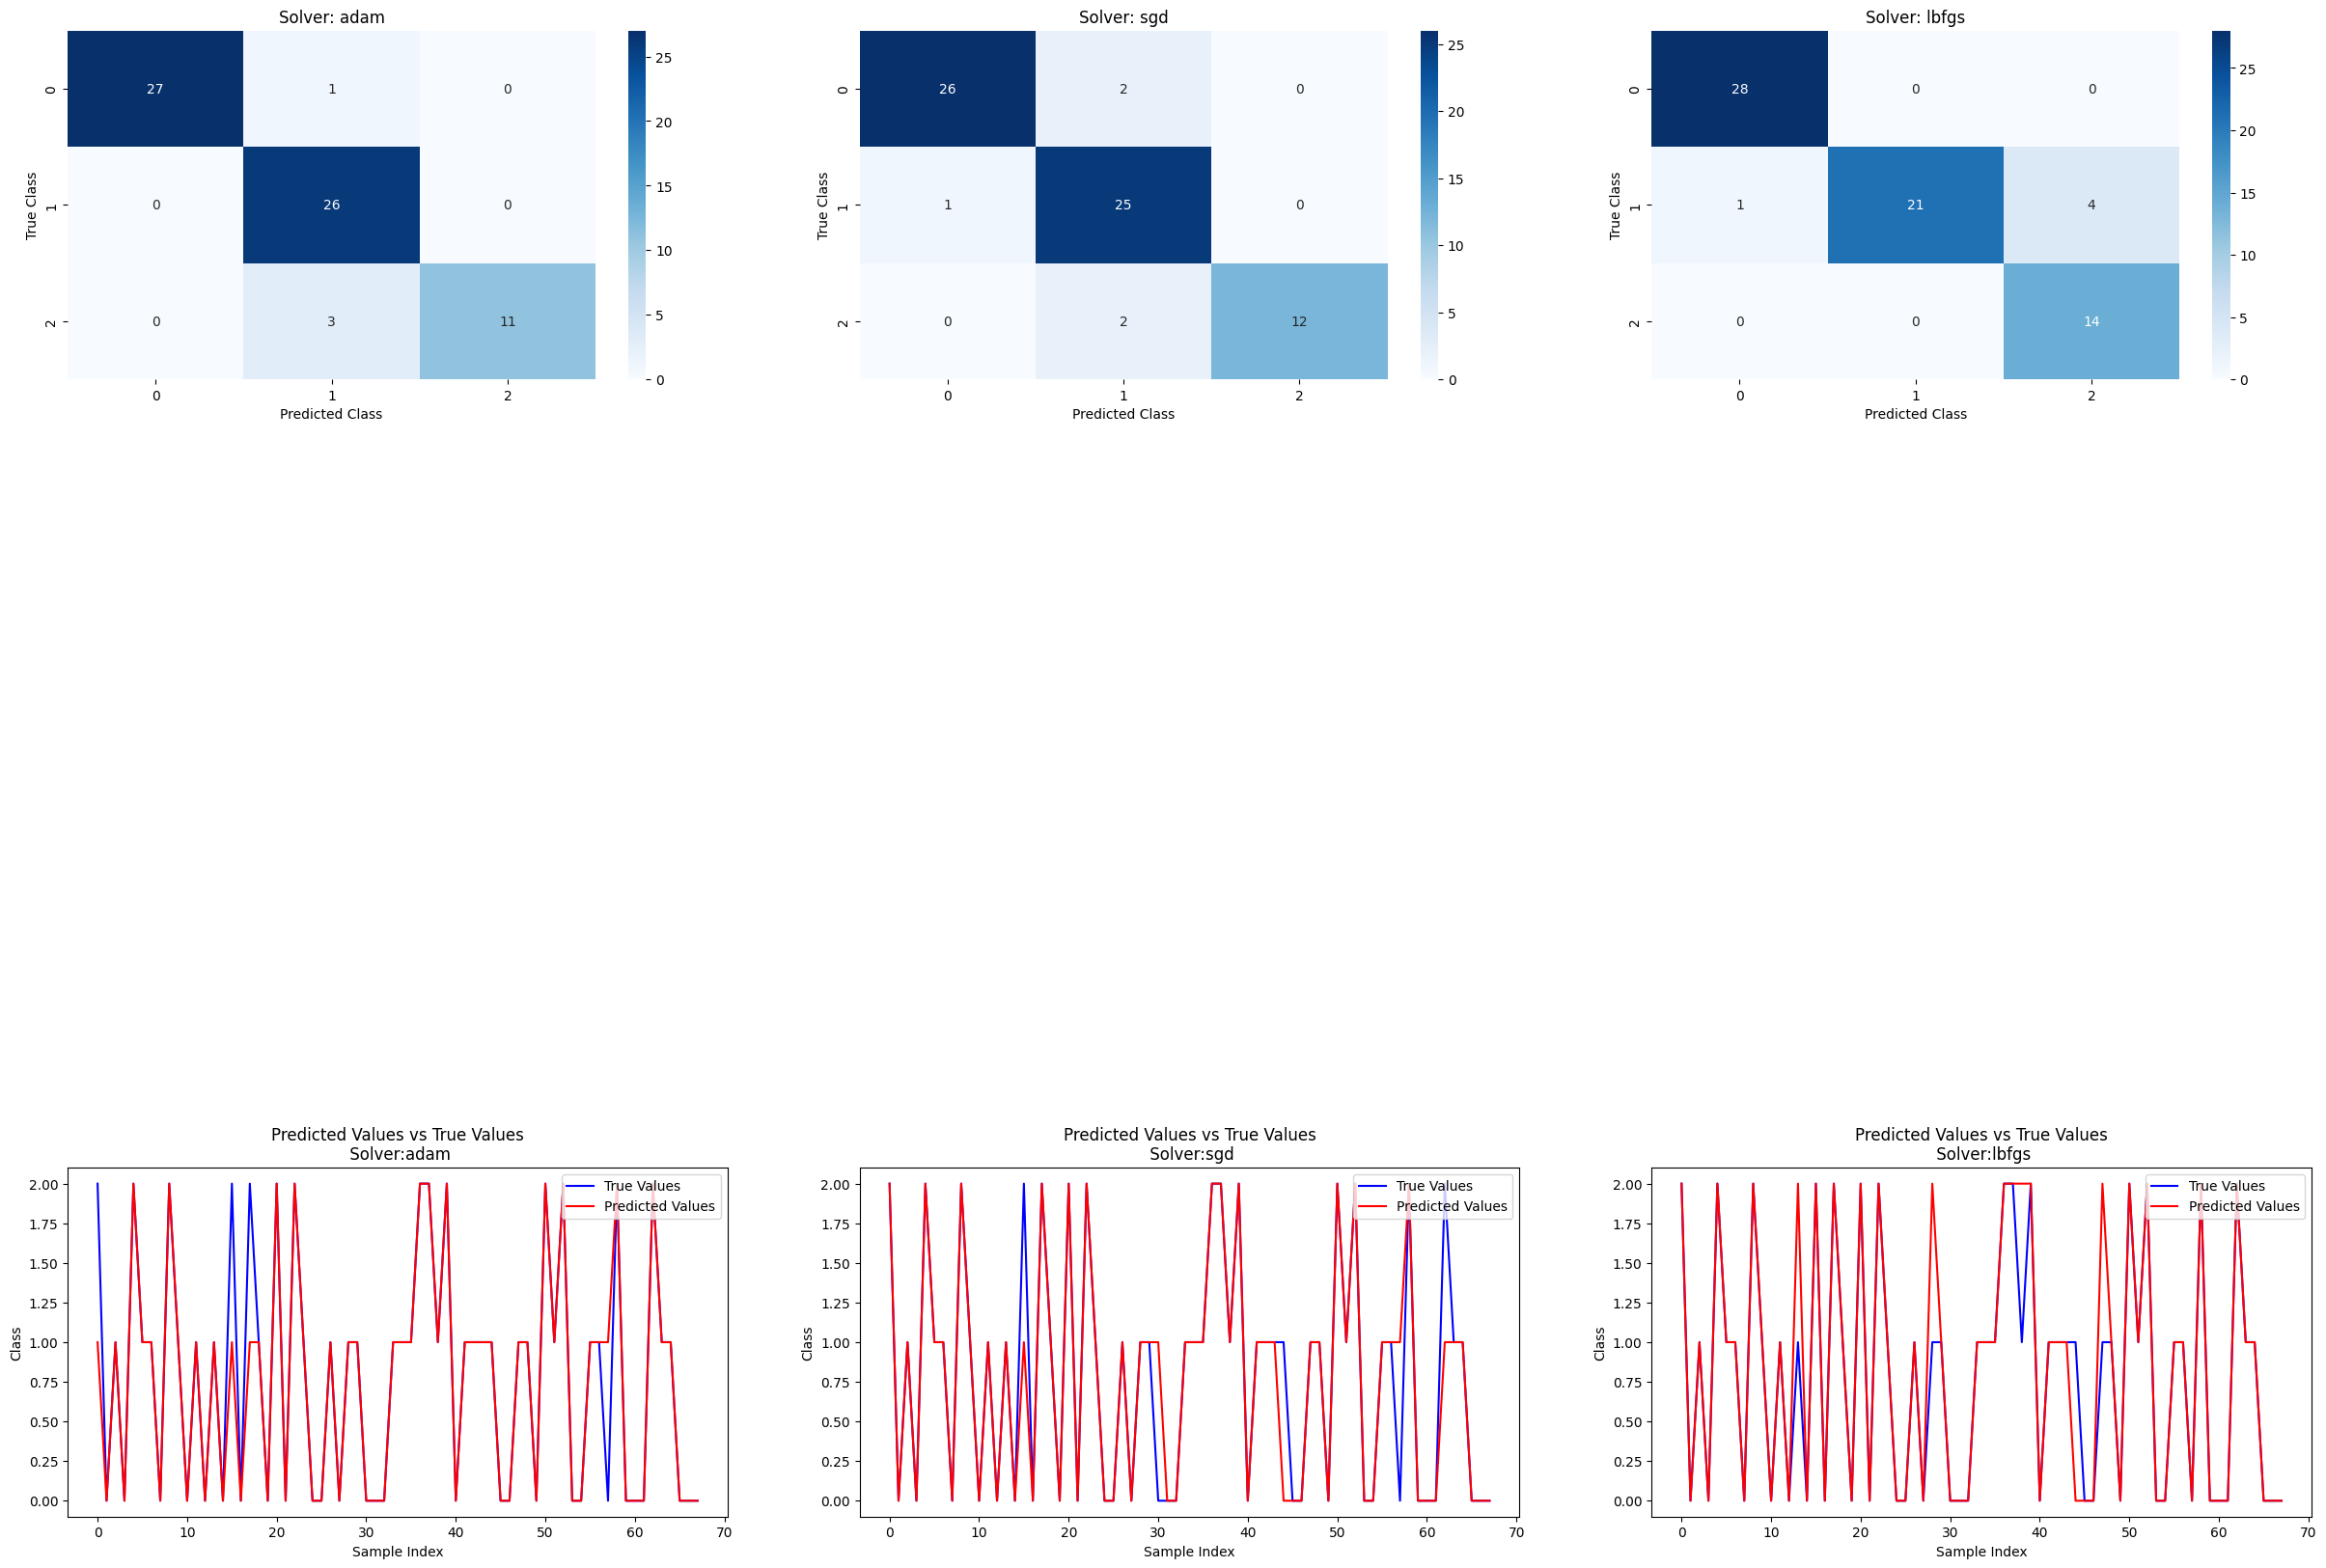

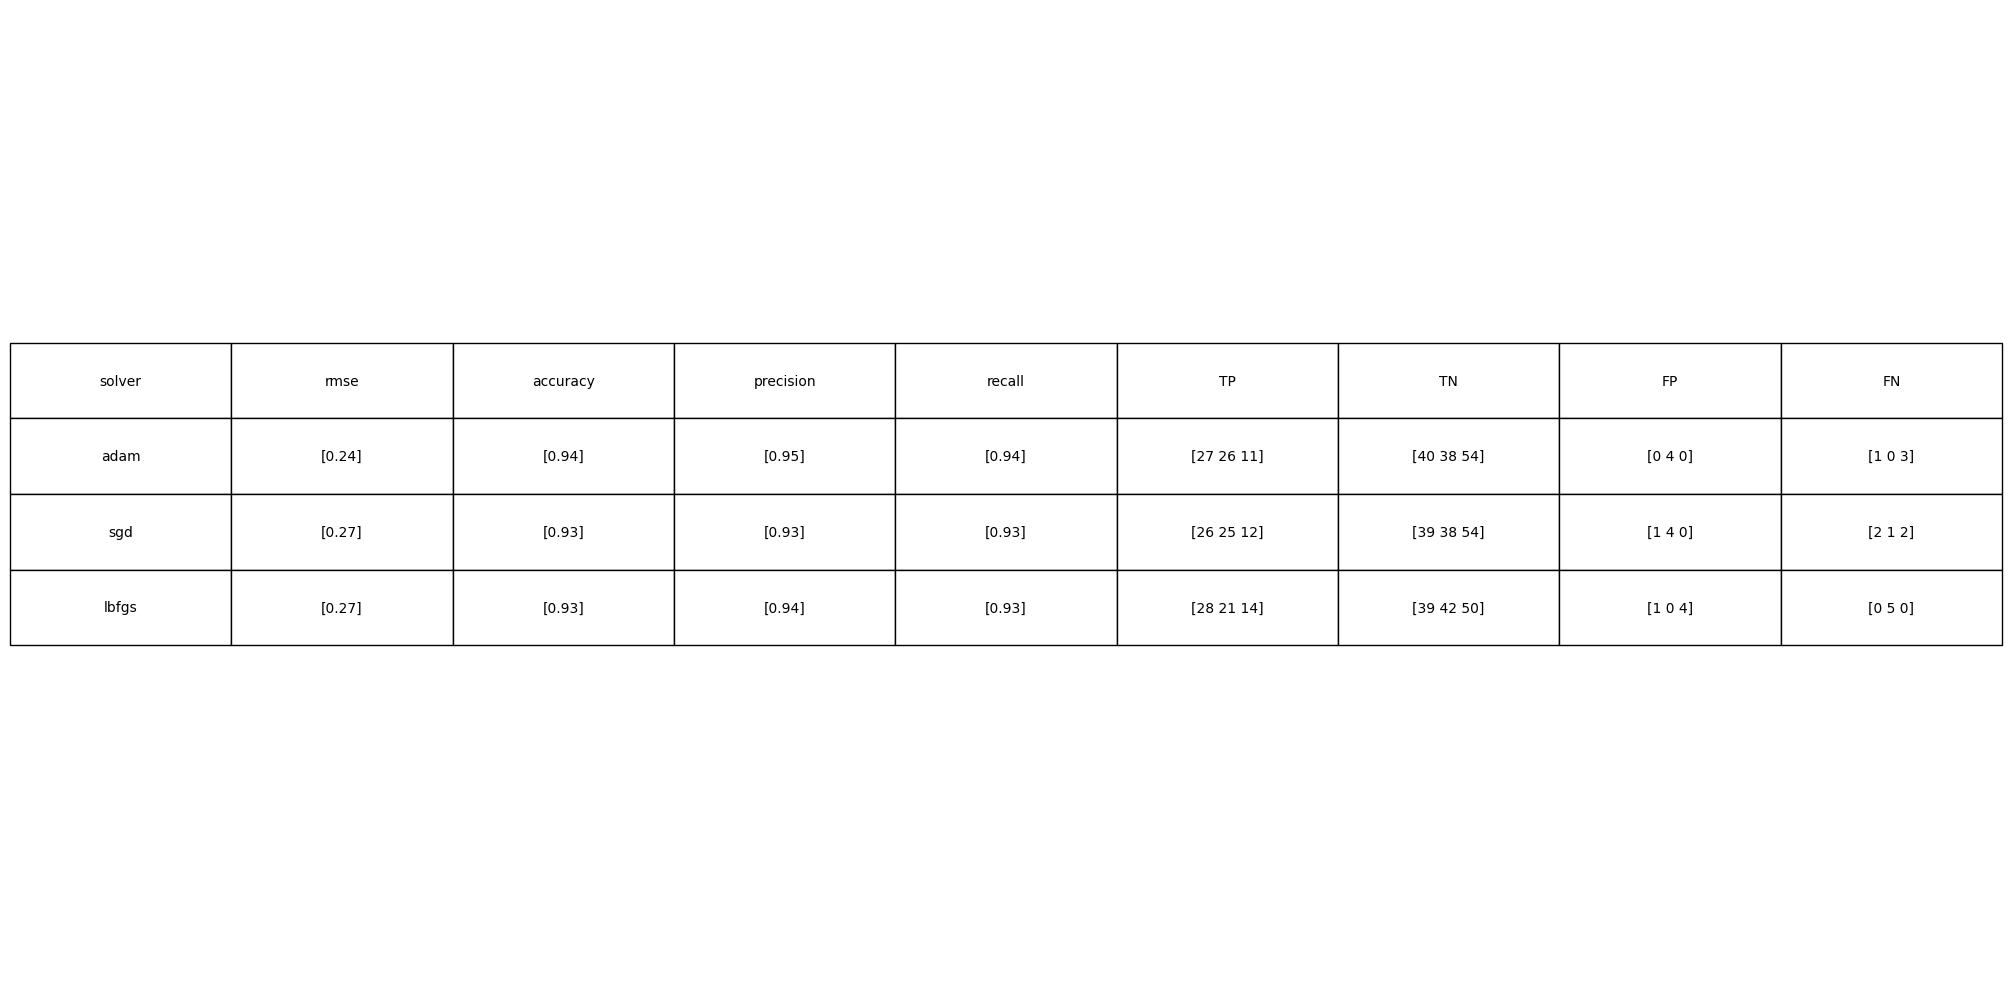

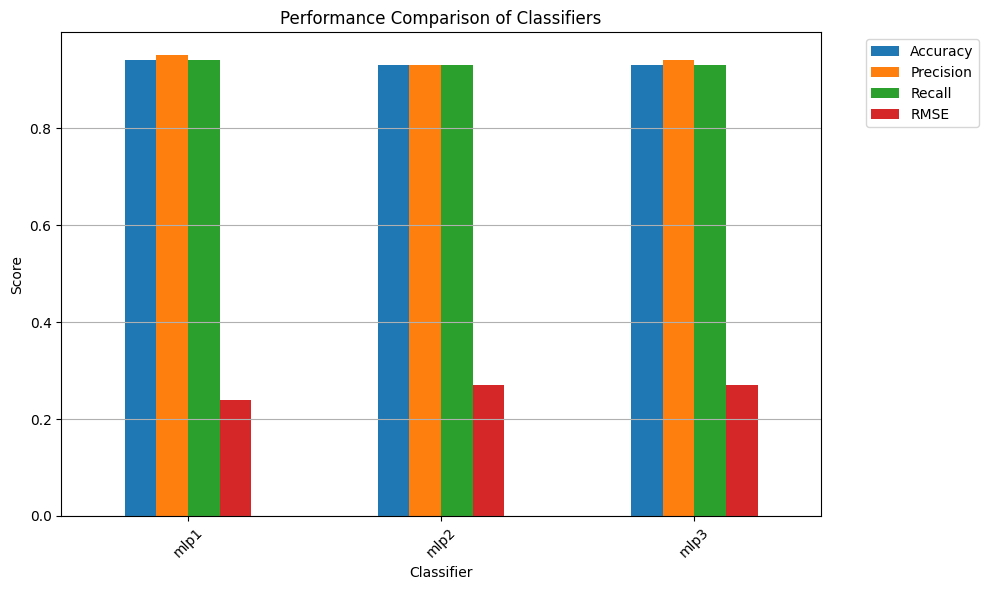

{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 3, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.94


In [8]:
#d)
print(best_accuracy)
print(best_mlp2.get_params())

param_grid = {

    'solver': ['adam', 'sgd', 'lbfgs']  # Dodajte različite vrijednosti za learning rate
     # Dodajte različite vrijednosti learning ratea
}

# Initialize the results list
results_list = []
plt.figure(figsize=(30, 20))
scores_d = []


# Perform manual GridSearchCV to capture all metrics
for i, solver in enumerate(param_grid['solver']):


        fold_results = {
            'solver': solver,
            'rmse': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'TP': [],
            'TN': [],
            'FP': [],
            'FN': []
        }
        name = f'mlp{i+1}'

        #mlp = MLPClassifier(max_iter=500,solver = solver, random_state=3)
        mlp = clone (best_mlp)
        mlp.set_params(solver = solver)
        # Train the model
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Calculate TP, TN, FP, FN for each class
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        # Define subplot positions
        plt.subplot(3, len(param_grid['solver']), i + 1)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Solver: {solver}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('MLP_konfmatrica_d.png')

        # Calculate metrics
        rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(2)
        accuracy = accuracy_score(y_test, y_pred).round(2)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0).round(2)
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_mlp2 = mlp
            best_mlp = mlp
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0).round(2)

        score_dict = {'Classifier': name,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'RMSE': rmse }
        scores_d.append(score_dict)
        fold_results['rmse'].append(rmse)
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['TP'] = TP
        fold_results['TN'] = TN
        fold_results['FP'] = FP
        fold_results['FN'] = FN

        plt.subplot(3,3 , i + 7)  # Za predikcije
        plt.plot(y_test, color='blue', label='True Values')
        plt.plot(y_pred, color='red', label='Predicted Values')
        plt.title(f'Predicted Values vs True Values\n Solver:{solver}')
        plt.xlabel('Sample Index')
        plt.ylabel('Class')
        plt.legend()

        results_list.append(fold_results)

plt.subplots_adjust(hspace=0.63) #razmak izmedju redova

# Create DataFrame from results_list
results_df = pd.DataFrame(results_list).astype(str)
#print(results_df)
plt.figure(figsize=(20, 10))
# Plot the table
plt.axis('off')  # Turn off the axis
tbl = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 3.6)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('MLP_tabela_d.png')

# Plotting
model_compare = pd.DataFrame(scores_d)

model_compare.set_index('Classifier', inplace=True)  # Postavljanje klasifikatora kao indeksa
model_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotacija oznaka na x-osi za bolju čitljivost
plt.grid(axis='y')  # Prikaz mreže na y-osi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Prikaz legende izvan grafikona
plt.tight_layout()  # Postavljanje razmaka između podataka radi bolje čitljivosti
plt.show()

print(best_mlp2.get_params())
print(best_accuracy)

0.94
{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 3, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


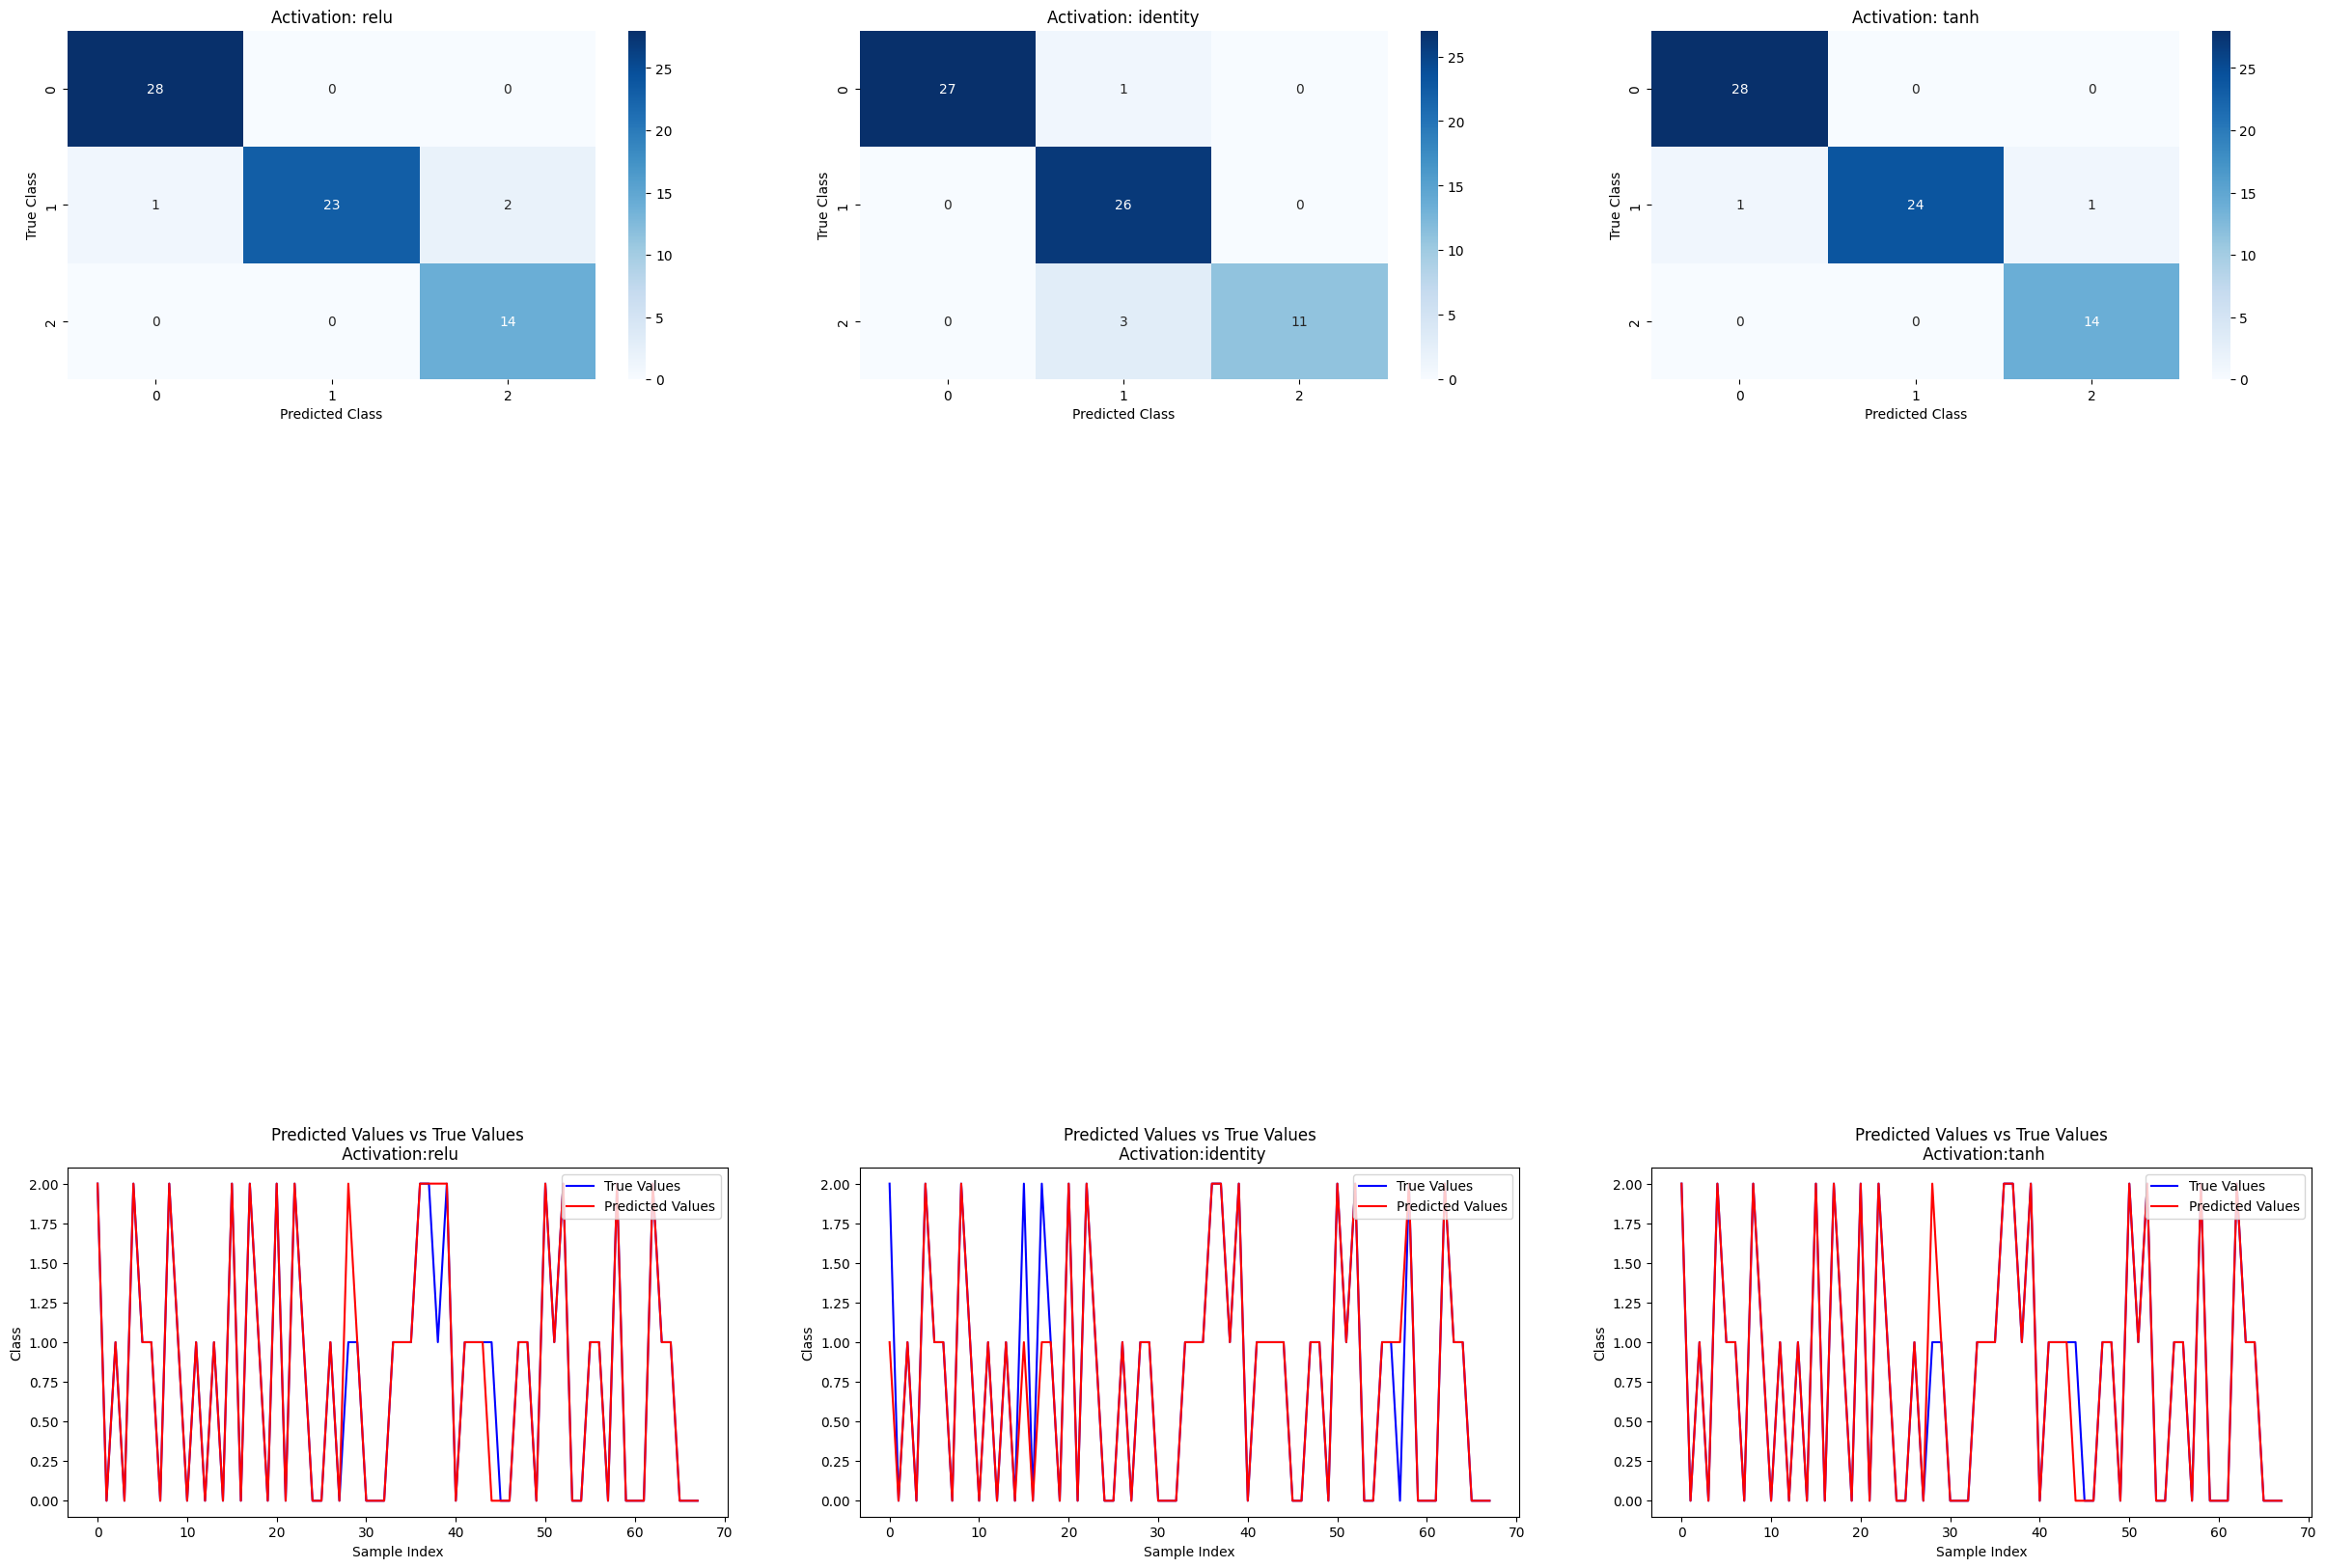

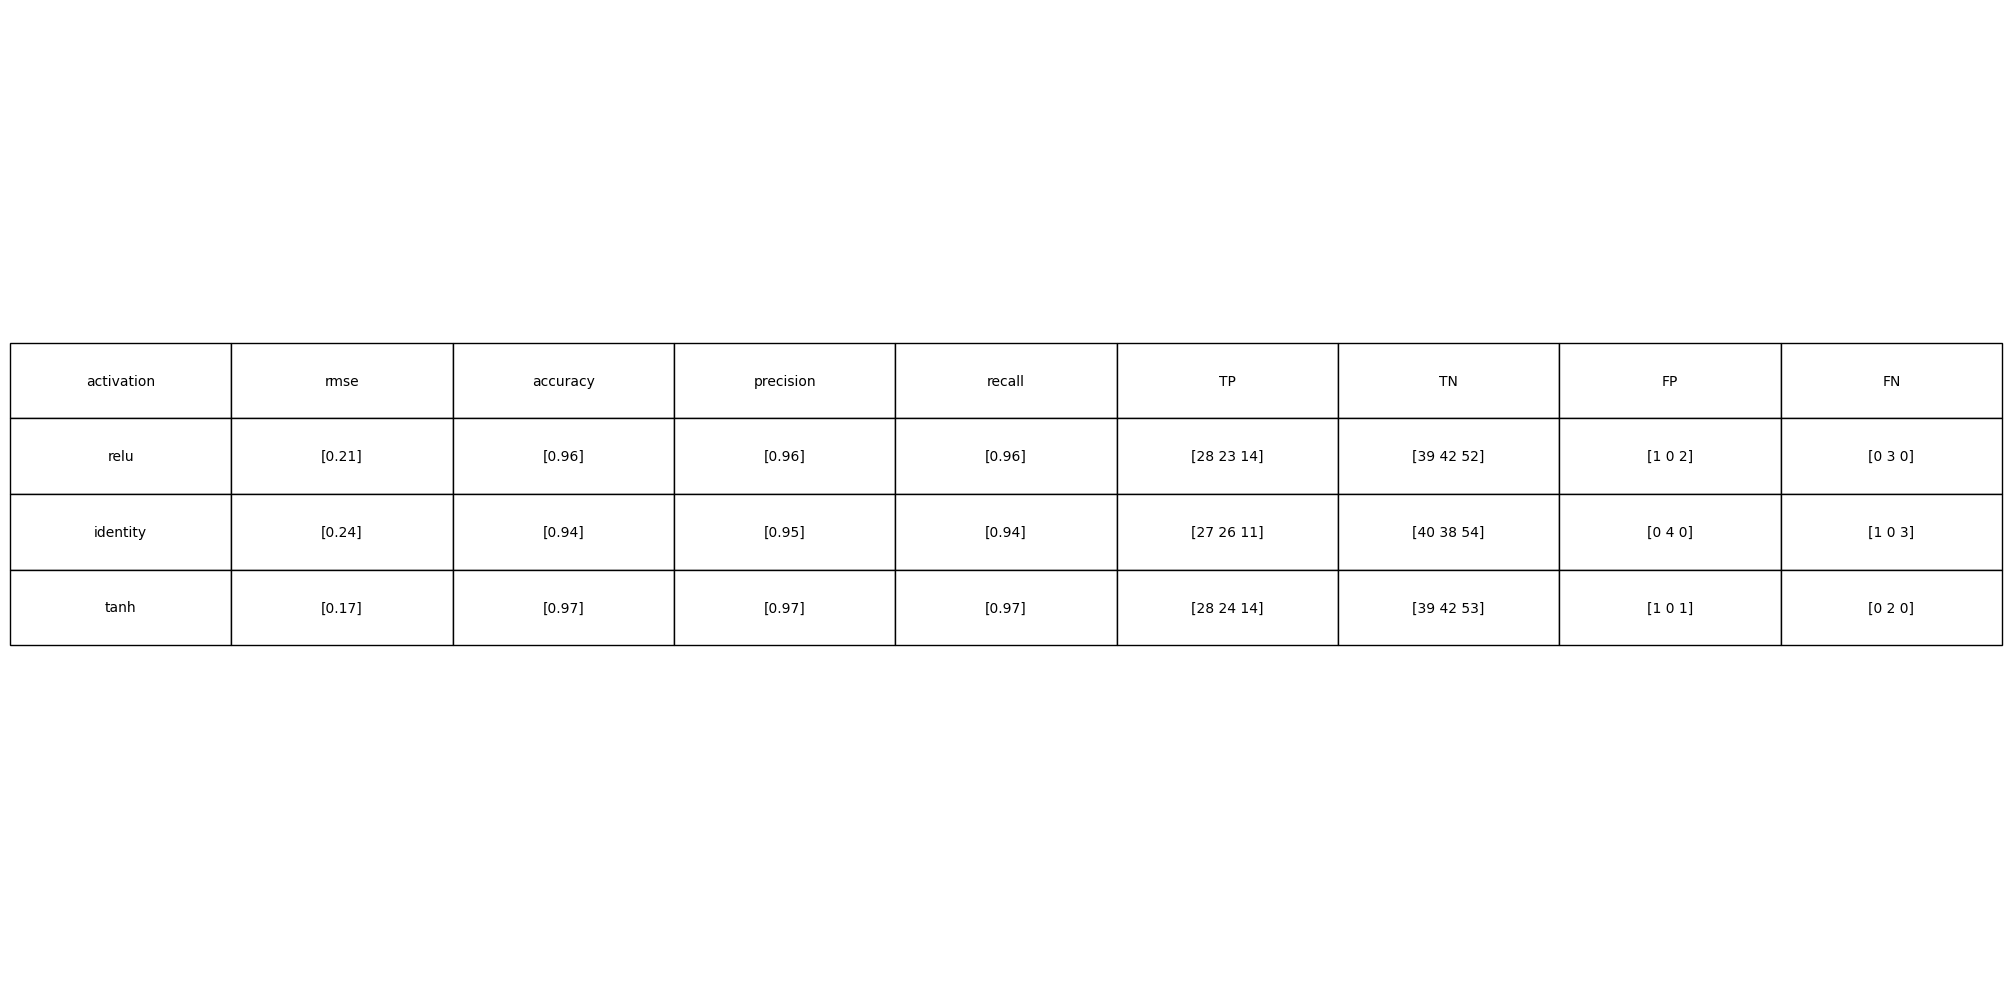

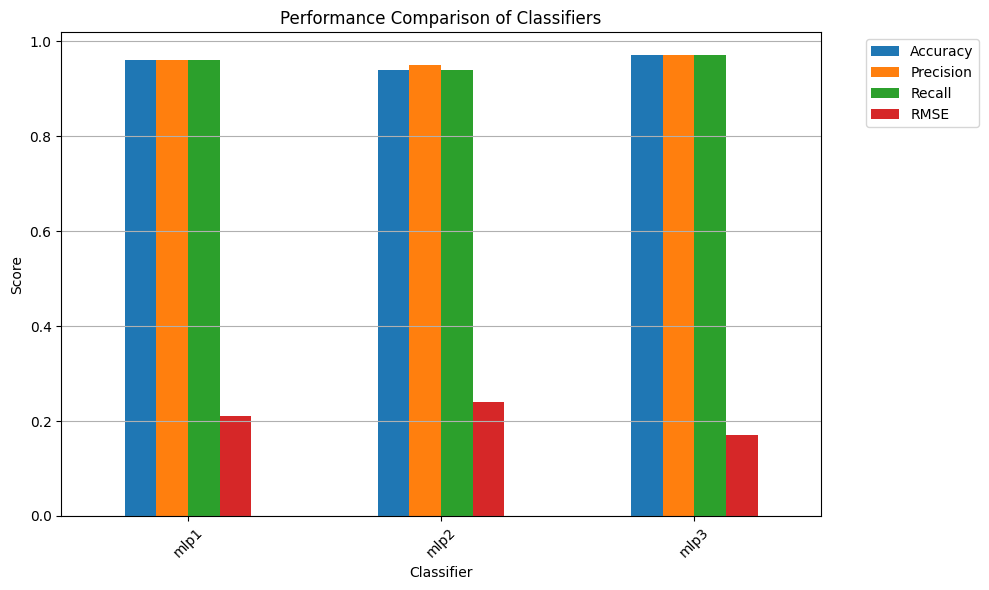

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 3, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.97


In [9]:
# e) Dodatni tuning

print(best_accuracy)
print(best_mlp2.get_params())

param_grid = {

    'activation': ['relu', 'identity', 'tanh']  # Dodajte različite vrijednosti za learning rate
     # Dodajte različite vrijednosti learning ratea
}

# Initialize the results list
results_list = []
plt.figure(figsize=(30, 20))
scores_e = []


# Perform manual GridSearchCV to capture all metrics
for i, activation in enumerate(param_grid['activation']):


        fold_results = {
            'activation': activation,
            'rmse': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'TP': [],
            'TN': [],
            'FP': [],
            'FN': []
        }
        name = f'mlp{i+1}'

        #mlp = MLPClassifier(max_iter=500,solver = solver, random_state=3)
        mlp = clone (best_mlp2)
        mlp.set_params(activation = activation)
        # Train the model
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        # Calculate TP, TN, FP, FN for each class
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (TP + FP + FN)

        # Define subplot positions
        plt.subplot(3, len(param_grid['activation']), i + 1)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Activation: {activation}')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.savefig('MLP_konfmatrica_d.png')

        # Calculate metrics
        rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(2)
        accuracy = accuracy_score(y_test, y_pred).round(2)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0).round(2)
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_mlp2 = mlp
            best_mlp = mlp
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0).round(2)

        score_dict = {'Classifier': name,
                  'Accuracy': accuracy,
                  'Precision': precision,
                  'Recall': recall,
                  'RMSE': rmse }
        scores_e.append(score_dict)
        fold_results['rmse'].append(rmse)
        fold_results['accuracy'].append(accuracy)
        fold_results['precision'].append(precision)
        fold_results['recall'].append(recall)
        fold_results['TP'] = TP
        fold_results['TN'] = TN
        fold_results['FP'] = FP
        fold_results['FN'] = FN

        plt.subplot(3,3 , i + 7)  # Za predikcije
        plt.plot(y_test, color='blue', label='True Values')
        plt.plot(y_pred, color='red', label='Predicted Values')
        plt.title(f'Predicted Values vs True Values\n Activation:{activation}')
        plt.xlabel('Sample Index')
        plt.ylabel('Class')
        plt.legend()

        results_list.append(fold_results)
plt.subplots_adjust(hspace=0.63) #razmak izmedju redova

# Create DataFrame from results_list
results_df = pd.DataFrame(results_list).astype(str)
#print(results_df)
plt.figure(figsize=(20, 10))
# Plot the table
plt.axis('off')  # Turn off the axis
tbl = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 3.6)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('MLP_tabela_d.png')

# Plotting
model_compare = pd.DataFrame(scores_e)

model_compare.set_index('Classifier', inplace=True)  # Postavljanje klasifikatora kao indeksa
model_compare.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Rotacija oznaka na x-osi za bolju čitljivost
plt.grid(axis='y')  # Prikaz mreže na y-osi
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Prikaz legende izvan grafikona
plt.tight_layout()  # Postavljanje razmaka između podataka radi bolje čitljivosti
plt.show()

print(best_mlp.get_params())
print(best_accuracy)